<a href="https://colab.research.google.com/github/suchkristenwow/LIO-SAM/blob/master/RestoreBot_(Plant)_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)

import matplotlib
import matplotlib.pyplot as plt

def cv2_imshow(img):
  plt.imshow(img[:,:,::-1])

import os
import glob


1.12.0+cu113
0.13.0+cu113


In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, GenericMask
from detectron2.data import MetadataCatalog, DatasetCatalog

import pycocotools
# from pycocotools import mask as coco_mask_tool
# import pycocotools.mask as mask_util
from detectron2.structures import BoxMode
from detectron2.structures.masks import BitMasks, Boxes

ModuleNotFoundError: ignored

In [ ]:
import numpy as np
from itertools import groupby

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

In [ ]:
import pdb
# _classes = ["control", "dip", "litter", "crack"]
_classes = ["SATR", "LAOC", "ERTR", "SPGR", "ERCI", "EUFE"]
def get_data_dicts(img_dir):
    dataset_dicts = []
    image_token = "image_"
    mask_token = "_mask_"
    for filename in os.listdir(img_dir):
        is_image_file = image_token in filename and "marker" not in filename and mask_token not in filename
        if is_image_file:
            im_filename = f"{img_dir}/{filename}"
            try:
              height, width = cv2.imread(im_filename).shape[:2]
            except Exception:
              print(im_filename)
              raise

            timestamp = filename.split(image_token)[1].split("_")[0].split(".png")[0]
            

            record = {}
            record["file_name"] = im_filename
            record["image_id"] = timestamp
            record["height"] = height
            record["width"] = width
            record["annotations"] = []

            glob_expr = f"{img_dir}/image_{timestamp}*"
            # pdb.set_trace()
            for _fname in glob.glob(glob_expr):
                if mask_token in _fname:
                    mask_filename = _fname
                    mask_type = mask_filename.split(mask_token)[1].split("_")[0].split(".")[0]
                    mask_type_idx = _classes.index(mask_type)
                    mask = cv2.imread(mask_filename, cv2.IMREAD_GRAYSCALE)
                    bitmasks = BitMasks([mask])
                    boxes = bitmasks.get_bounding_boxes()
                    # rle = binary_mask_to_rle(mask)
                    obj = {
                      "bbox": boxes.tensor[0].tolist(),
                      "bbox_mode": BoxMode.XYXY_ABS,
                      # "segmentation": pycocotools.mask.frPyObjects(rle, rle['size'][0], rle['size'][1]),
                      "segmentation": pycocotools.mask.encode(np.asarray(mask, order="F")),
                      # "segmentation": binary_mask_to_rle(mask),
                      "_mask": mask,
                      "category_id": mask_type_idx,
                    }
                    record["annotations"].append(obj)            
            dataset_dicts.append(record)
    return dataset_dicts

image_data_path = f"{os.getcwd()}/restore_bot/v3_images_with_masks"
#image_data_path = f"{os.getcwd()}/restore_bot/v3_images_with_masks"
for d in ["train", "val"]:
    DatasetCatalog.register(f"image_data_{d}", lambda d=d: get_data_dicts(image_data_path + "/" + d))
    MetadataCatalog.get(f"image_data_{d}").set(thing_classes=_classes)

image_metadata = MetadataCatalog.get("image_data_train")

In [ ]:
print(image_data_path)

/home/mike_l/restore_bot/v3_images_with_masks


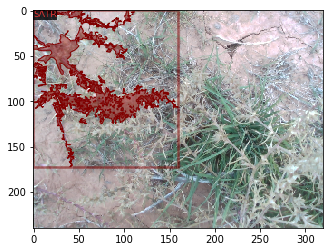

In [ ]:
dataset_dicts = get_data_dicts(os.path.join(image_data_path, "train"))
d = dataset_dicts[1]
# TODO: figure out why the mask run length encoding (rle) doesn't work here
for annotation in d["annotations"]:
    annotation["segmentation"] = annotation["_mask"]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=image_metadata, scale=0.5)
out = visualizer.draw_dataset_dict(d)
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
cfg = get_cfg()

# cfg.MODEL.DEVICE = "cpu" 

cfg.INPUT.MASK_FORMAT = 'bitmask'

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("image_data_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
# cfg.SOLVER.MAX_ITER = 200    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.MAX_ITER = 800
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(_classes)  # see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

In [ ]:
from detectron2.engine import DefaultTrainer
cfg.OUTPUT_DIR = "restore_bot/output"
print(cfg.OUTPUT_DIR)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

restore_bot/output
[01/18 15:09:56 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (6, 256, 1, 1) 

[01/18 15:10:00 d2.engine.train_loop]: Starting training from iteration 0


/home/mike_l/restore_bot/old/detectron2/detectron2/data/detection_utils.py:421: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/home/mike_l/restore_bot/old/detectron2/detectron2/data/detection_utils.py:421: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor.

[01/18 15:10:05 d2.utils.events]:  eta: 0:02:43  iter: 19  total_loss: 2.695  loss_cls: 1.736  loss_box_reg: 0.08268  loss_mask: 0.6936  loss_rpn_cls: 0.1551  loss_rpn_loc: 0.0211  time: 0.2128  data_time: 0.0164  lr: 6.1816e-06  max_mem: 2961M
[01/18 15:10:09 d2.utils.events]:  eta: 0:02:49  iter: 39  total_loss: 2.357  loss_cls: 1.428  loss_box_reg: 0.08053  loss_mask: 0.6935  loss_rpn_cls: 0.1261  loss_rpn_loc: 0.01705  time: 0.2188  data_time: 0.0064  lr: 1.2425e-05  max_mem: 2961M
[01/18 15:10:13 d2.utils.events]:  eta: 0:02:41  iter: 59  total_loss: 1.773  loss_cls: 0.8628  loss_box_reg: 0.08645  loss_mask: 0.693  loss_rpn_cls: 0.07622  loss_rpn_loc: 0.01394  time: 0.2174  data_time: 0.0067  lr: 1.8669e-05  max_mem: 2961M
[01/18 15:10:18 d2.utils.events]:  eta: 0:02:38  iter: 79  total_loss: 1.304  loss_cls: 0.3854  loss_box_reg: 0.09661  loss_mask: 0.692  loss_rpn_cls: 0.1111  loss_rpn_loc: 0.01686  time: 0.2184  data_time: 0.0067  lr: 2.4913e-05  max_mem: 2961M
[01/18 15:10:22 

In [ ]:
# Run this without training

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained

from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling import build_model

# Minimum score threshold (assuming scores in a [0, 1] range); a value chosen to
# balance obtaining high recall with not having too many low precision
# detections that will slow down inference post processing steps (like NMS)
# A default threshold of 0.0 increases AP by ~0.2-0.3 but significantly slows down
# inference.
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold

predictor = DefaultPredictor(cfg)

model = build_model(cfg)
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)
model.eval()
print()

/home/mike_l/restore_bot/v3_images_with_masks/val/image_1636488270.png
/home/mike_l/restore_bot/v3_images_with_masks/val/image_1636488090.png
/home/mike_l/restore_bot/v3_images_with_masks/val/image_1636486530.png
/home/mike_l/restore_bot/v3_images_with_masks/val/image_1636481213.png


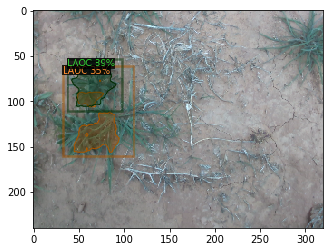

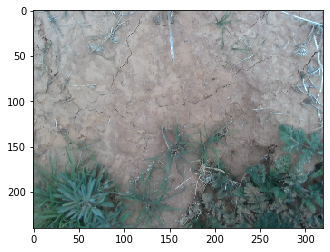

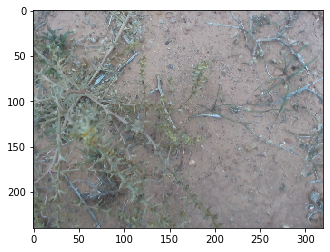

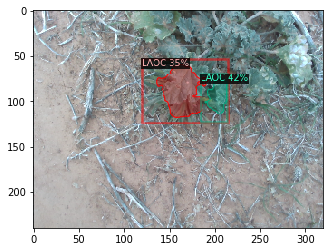

In [ ]:
# Then, we randomly select several samples to visualize the prediction results.

from detectron2.utils.visualizer import ColorMode
image_data_path = f"{os.getcwd()}/restore_bot/v3_images_with_masks"
dataset_dicts = get_data_dicts(os.path.join(image_data_path, "val"))

for idx, d in enumerate(dataset_dicts):
  print(d["file_name"])
  im = cv2.imread(d["file_name"])
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                  metadata=image_metadata, 
                  scale=0.5, 
                  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
  )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  plt.imsave(f"restore_bot/output/out{idx}.png", out.get_image())
  plt.figure()
  cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader


In [ ]:
# Can patch evaluator to show mean IOU
# evaluator = PatchedCOCOEvaluator("v1_val", cfg, False, output_dir=f"restore_bot/output")
evaluator = COCOEvaluator("image_data_val", cfg, False, output_dir=f"restore_bot/output")
val_loader = build_detection_test_loader(cfg, "image_data_val")
print(inference_on_dataset(model, val_loader, evaluator))

WARNING [01/18 15:13:09 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/18 15:13:09 d2.evaluation.coco_evaluation]: 'image_data_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[01/18 15:13:09 d2.data.datasets.coco]: Converting annotations of dataset 'image_data_val' to COCO format ...)
[01/18 15:13:09 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[01/18 15:13:09 d2.data.datasets.coco]: Conversion finished, #images: 4, #annotations: 10
[01/18 15:13:09 d2.data.datasets.coco]: Caching COCO format annotations at 'restore_bot/output/image_data_val_coco_format.json' ...
[01/18 15:13:10 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------